In [1]:
import os, sys
import pickle
import numpy as np
import tensorflow as tf

In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
class MsurvEmu(tf.keras.Model):
    """ emulator for Msurvive
    """

    def __init__(self, n_parameters=None, n_hidden=[50,50], restore=False, restore_filename=None, optimizer=tf.keras.optimizers.Adam()):
        """
        Constructor.
        :param n_parameters: number of SED model parameters (inputs to the network)
        :param n_hiddens: list with number of hidden units for each hidden layer
        :param restore: (bool) whether to restore an previously trained model or not
        :param restore_filename: filename tag (without suffix) for restoring trained model from file (this will be a pickle file with all of the model attributes and weights)
        """

        # super
        super(MsurvEmu, self).__init__()

        # restore
        if restore is True:
            self.restore(restore_filename)

        # else set variables from input parameters
        else:
            # parameters
            self.n_parameters = n_parameters
            self.n_hidden = n_hidden

            # architecture
            self.architecture = [self.n_parameters] + self.n_hidden + [1]
            self.n_layers = len(self.architecture) - 1

        # trainable variables...

        # weights, biases and activation function parameters for each layer of the network
        self.W = []
        self.b = []
        self.alphas = []
        self.betas = []
        for i in range(self.n_layers):
            self.W.append(tf.Variable(tf.random.normal([self.architecture[i], self.architecture[i+1]], 0., np.sqrt(2./self.n_parameters)), name="W_" + str(i)))
            self.b.append(tf.Variable(tf.zeros([self.architecture[i+1]]), name = "b_" + str(i)))
        for i in range(self.n_layers-1):
            self.alphas.append(tf.Variable(tf.random.normal([self.architecture[i+1]]), name = "alphas_" + str(i)))
            self.betas.append(tf.Variable(tf.random.normal([self.architecture[i+1]]), name = "betas_" + str(i)))

        # restore weights if restore = True
        if restore is True:
            for i in range(self.n_layers):
                self.W[i].assign(self.W_[i])
                self.b[i].assign(self.b_[i])
            for i in range(self.n_layers-1):
                self.alphas[i].assign(self.alphas_[i])
                self.betas[i].assign(self.betas_[i])

        self.optimizer = optimizer

    # non-linear activation function
    def activation(self, x, alpha, beta):

        return tf.multiply(tf.add(beta, tf.multiply(tf.sigmoid(tf.multiply(alpha, x)), tf.subtract(1.0, beta)) ), x)

    # call: forward pass through the network to predict pca coefficients
    @tf.function
    def call(self, parameters):

        layer = parameters
        for i in range(self.n_layers - 1):
            out = tf.add(tf.matmul(layer, self.W[i]), self.b[i])
            layer = self.activation(out, self.alphas[i], self.betas[i])

        return tf.add(tf.matmul(layer, self.W[-1]), self.b[-1])

    # save network parameters to numpy arrays
    def update_emulator_parameters(self):

        # put network parameters to numpy arrays
        self.W_ = [self.W[i].numpy() for i in range(self.n_layers)]
        self.b_ = [self.b[i].numpy() for i in range(self.n_layers)]
        self.alphas_ = [self.alphas[i].numpy() for i in range(self.n_layers-1)]
        self.betas_ = [self.betas[i].numpy() for i in range(self.n_layers-1)]
        
    # save
    def save(self, filename):

        # attributes
        attributes = [self.W_,
                      self.b_,
                      self.alphas_,
                      self.betas_,
                      self.n_parameters,
                      self.n_hidden,
                      self.n_layers,
                      self.architecture]

        # save attributes to file
        f = open(filename + ".pkl", 'wb')
        pickle.dump(attributes, f)
        f.close()

    ### Infrastructure for network training ###

    @tf.function
    def compute_loss(self, theta, pca):
        return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(self.call(theta), pca)))

    @tf.function
    def compute_loss_and_gradients(self, theta, pca):

        # compute loss on the tape
        with tf.GradientTape() as tape:

            # loss
            loss = tf.sqrt(tf.reduce_mean(tf.math.squared_difference(self.call(theta), pca)))

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        return loss, gradients

    def training_step(self, theta, pca):

        # compute loss and gradients
        loss, gradients = self.compute_loss_and_gradients(theta, pca)

        # apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss

    def training_step_with_accumulated_gradients(self, theta, pca, accumulation_steps=10):

        # create dataset to do sub-calculations over
        dataset = tf.data.Dataset.from_tensor_slices((theta, pca)).batch(int(theta.shape[0]/accumulation_steps))

        # initialize gradients and loss (to zero)
        accumulated_gradients = [tf.Variable(tf.zeros_like(variable), trainable=False) for variable in self.trainable_variables]
        accumulated_loss = tf.Variable(0., trainable=False)

        # loop over sub-batches
        for theta_, pca_ in dataset:

            # calculate loss and gradients
            loss, gradients = self.compute_loss_and_gradients(theta_, pca_)

            # update the accumulated gradients and loss
            for i in range(len(accumulated_gradients)):
                accumulated_gradients[i].assign_add(gradients[i]*theta_.shape[0]/theta.shape[0])
                accumulated_loss.assign_add(loss*theta_.shape[0]/theta.shape[0])

        # apply accumulated gradients
        self.optimizer.apply_gradients(zip(accumulated_gradients, self.trainable_variables))

        return accumulated_loss

In [4]:
########################################################
# load training data
########################################################
dat_dir = '/scratch/gpfs/chhahn/provabgs/mass_surviving'

sps     = []
tage    = []
msurv   = []
for i in range(6):
    sps.append(np.load(os.path.join(dat_dir, 'msurv.%i.sps.npy' % i)))
    tage.append(np.load(os.path.join(dat_dir, 'msurv.%i.tage.npy' % i)))
    msurv.append(np.load(os.path.join(dat_dir, 'msurv.nmf.%i.msurv.npy' % i)))
sps     = np.concatenate(sps, axis=0)
tage    = np.concatenate(tage, axis=0)
msurv   = np.concatenate(msurv, axis=0)


sps_t = np.zeros((sps.shape[0],3))
sps_t[:,0] = (1. - sps[:,0]).clip(1e-8, None)
for i in range(1,3):
    sps_t[:,i] = 1. - (sps[:,i] / np.prod(sps_t[:,:i], axis=1))

thetas = np.concatenate([sps_t, np.log10(sps[:,6:8]), tage[:,None]], axis=1)

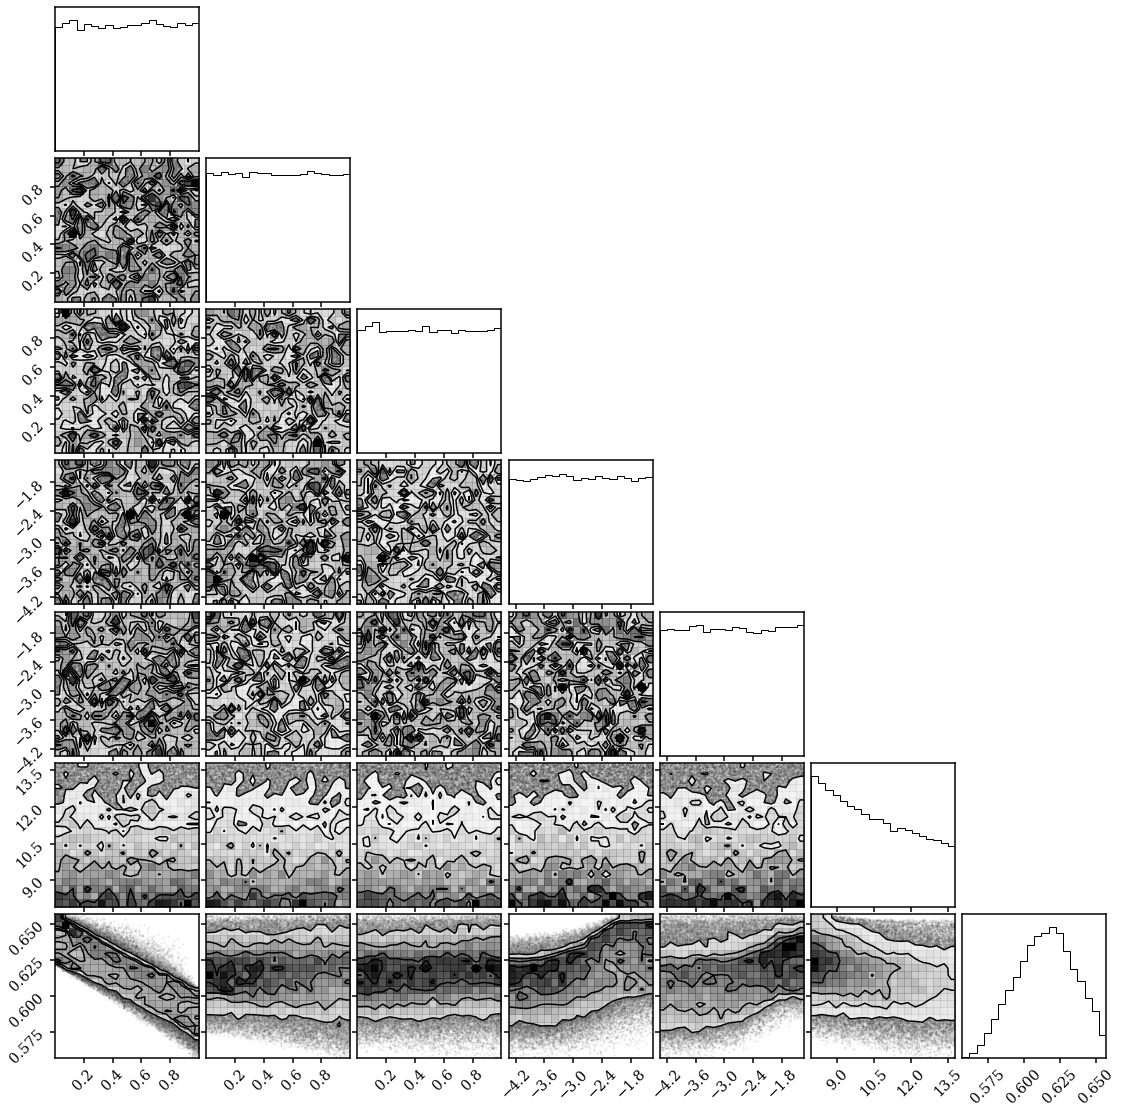

In [5]:
_ = DFM.corner(np.concatenate([thetas, msurv[:,None]], axis=1))

In [6]:
theta_shift = np.mean(thetas, axis=0)
theta_scale = np.std(thetas, axis=0)

_thetas = (thetas - theta_shift) / theta_scale

In [7]:
msurv_shift = np.mean(msurv, axis=0)
msurv_scale = np.std(msurv, axis=0)

_msurvs = (msurv - msurv_shift) / msurv_scale

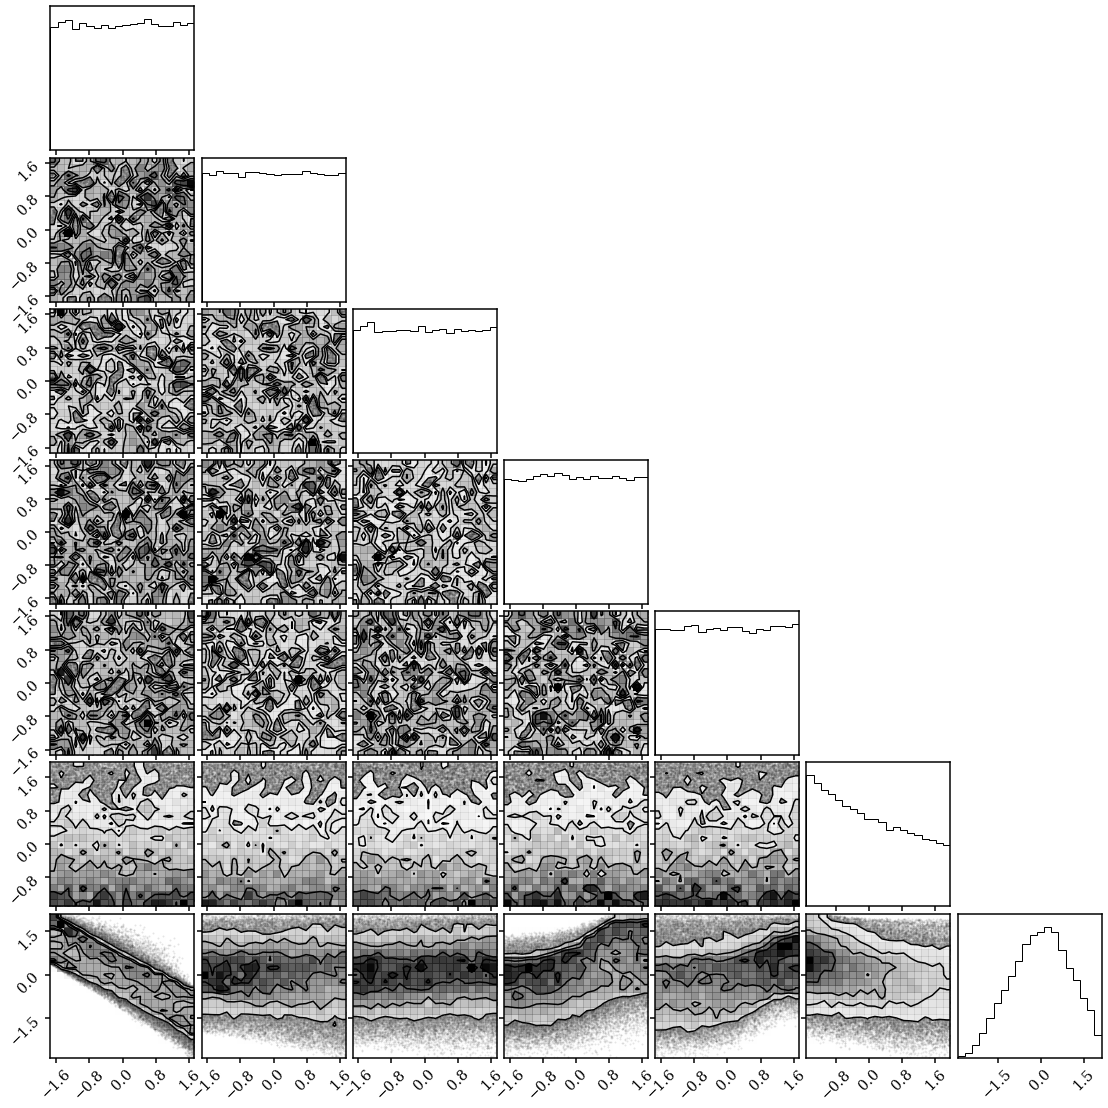

In [8]:
_ = DFM.corner(np.concatenate([_thetas, _msurvs[:,None]], axis=1))

In [9]:
Ntrain = int(0.9 * _thetas.shape[0])
Nvalid = _thetas.shape[0] - Ntrain
print('Ntrain = %i' % Ntrain)

theta_train = tf.convert_to_tensor(_thetas[:Ntrain,:].astype(np.float32))
msurv_train = tf.convert_to_tensor(_msurvs[:Ntrain].astype(np.float32))

# validation theta and pca
theta_valid = tf.convert_to_tensor(_thetas[Ntrain:,:].astype(np.float32))
msurv_valid = tf.convert_to_tensor(_msurvs[Ntrain:].astype(np.float32))

Ntrain = 54000


In [10]:
nbatch = 512
patience = 20

speculator = MsurvEmu(n_parameters=_thetas.shape[1], n_hidden=[128, 128, 128, 128, 128])

for lr in [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]: 
    speculator.optimizer.lr = lr

    # create iterable dataset (given batch size)
    training_data = tf.data.Dataset.from_tensor_slices((theta_train,
        msurv_train)).shuffle(theta_train.shape[0]).batch(nbatch)

    # set up training loss
    training_loss   = [np.infty]
    validation_loss = [np.infty]
    best_loss       = np.infty
    early_stopping_counter = 0

    # loop over epochs
    while early_stopping_counter < patience:

        # loop over batches
        train_loss, nb = 0, 0
        for theta, pca in training_data:
            # training step: check whether to accumulate gradients or not (only worth doing this for very large batch sizes)
            train_loss += speculator.training_step(theta, pca)
            nb += 1
        train_loss /= float(nb)
        training_loss.append(train_loss)

        # compute validation loss at the end of the epoch
        #     print(speculator.W[0].numpy())
        #     print(theta_valid[:10])
        #     print(np.array(speculator.call(theta_valid[:5])).flatten())
        #     print(np.array(speculator.call(theta_valid[5:10])).flatten())
        #     print(msurv_valid[:10])
        validation_loss.append(speculator.compute_loss(theta_valid, msurv_valid).numpy())
        print(speculator.compute_loss(theta_valid, msurv_valid).numpy())

        # early stopping condition
        if validation_loss[-1] < best_loss:
            best_loss = validation_loss[-1]
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            plt.scatter(msurv_valid.numpy() * msurv_scale + msurv_shift, speculator.call(theta_valid).numpy() * msurv_scale + msurv_shift)
            plt.plot([0., 1.], [0., 1.], c='k', ls='--')
            plt.xlim(0.55, 0.7)
            plt.ylim(0.55, 0.7)
            plt.show()

902.43866
606.3517
458.93243
379.67905
324.10275
300.0637
267.04517
243.24124
199.73538
191.91895
222.40846
165.34912
149.09863
160.02487
145.15854
129.33488


KeyboardInterrupt: 